# Shapelet based time series machine learning

In this notebook, our goal is to introduce the notions necessary to understand the use of Shapelets for time series machine learning. We provide both  theoritical knowledge, through formal definitions and references, and practical knowledge, to show how these theoritical concepts are used into the shapelet-based estimators available in `aeon`. We also show how to use the visualization tools associated with these estimators.

## A bit of theory : What are Shapelets ?
Before we introduce the definition of a shapelet, we must first introduce the definition of time series.

## Definition of a time series
In this notebook, we will denote a time series of length $n$ and of dimension $d$ as a vector $X = [\mathbf{x}_1, \ldots, \mathbf{x}_m]$ with $\mathbf{x}_j \in \mathbb{R}^d$. 

Inside aeon, we use the format `X : (n_channels, n_timepoints)`, with `X` a two dimensional array, where `n_channels` correspond to the dimension $d$, or the number of features, and `n_timepoints` to $m$, the number of measurement. Note that this definition implies that we have a fixed time interval between each time point (i.e. a time series with a fixed frequency). When $d=1$, $X$ is said to be univariate, and multivariate when $d>1$.

When talking about a time series dataset, we will use the notation ${\cal X} = [X_1, \ldots, X_n]$, which in code correspond to a three dimensional array of shape `X : (n_samples, n_channels, n_timepoints)`, with $n$ corresponding to `n_samples`, the number of time series composing the dataset ${\cal X}$. 

For example, we can use the GunPoint dataset :


In [1]:
from aeon.datasets import load_classification

X_train, y_train = load_classification("GunPoint", split="train")
X_test, y_test = load_classification("GunPoint", split="test")

print(f"shape of the array: {X_train.shape}")
print(f"n_samples = {X_train.shape[0]}")
print(f"n_channels = {X_train.shape[1]}")
print(f"n_timepoints = {X_train.shape[2]}")

shape of the array: (50, 1, 150)
n_samples = 50
n_channels = 1
n_timepoints = 150



**For the sake of simplicity and to help building intuition, we assume the following assumptions in the next definitions :**
- We only consider univariate time series ($d=1$)
- We only consider equal length time series ($m_i = m_j, \ \forall\ i,j \in [1,n] $)

We show how to generalize shapelet to these cases in later sections.

## Definition of a Shapelet
A Shapelet $S$ is defined as a time series subsequences, which, most of the time, is extracted from a training dataset ${\cal X}^{\ train}$. A shapelet, like a time series, is defined using a length parameter $l$, such as $S = [\mathbf{s}_1, \ldots,\mathbf{s}_l]$, where $l < m$. Remember that $m$ represent the length of a time series, if we had $l=m$, this would be somewhat equivalent to doing a $k$-nearest neighbor algorithm ! It is generaly consider that $l << m$, as a shapelet is supposed to represent a discriminative **subesquence**.

So, given our time series dataset, we could create a shapelet as follow :


In [2]:
length = 25  # the length of the shapelet
S = X_train[0, :, 45 : 45 + length]  # Set the shapelet values
print(S)

[[-0.64349171 -0.64265061 -0.6420974  -0.64447929 -0.6488921  -0.65765851
  -0.66120325 -0.64966432 -0.61016844 -0.53743483 -0.46503123 -0.35853483
  -0.28313648 -0.17744604  0.15824648  0.35028455  0.48241039  0.60380734
   0.79710411  0.98755132  1.2037853   1.4065415   1.5962459   1.7128307
   1.7788152 ]]


In aeon, we expose some visualization classes for shapelets to help create plots and understand what's going on behind the scene. We can for example, visualize the subsequence represented by the shapelet `S`: (note that the following might take a long time to import **for the first time on your system**, as it needs to import all shapelet-based estimator in aeon, with some needing some compilation work due to `numba`)

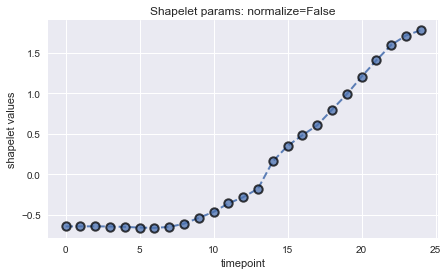

In [51]:
from aeon.visualisation import ShapeletVisualizer

shp_vis = ShapeletVisualizer(S)
fig = shp_vis.plot(figure_options={"figsize": (7, 4)})

Historicaly, shapelets were first proposed as a primitive for time series machine learning [[1]](https://www.cs.ucr.edu/~eamonn/shaplet.pdf) and were used as spliting criterion in a decision tree for time series classification. To make this work a distance $dist$ between a shapelet $S$ and a time series $X$ was defined such as $dist(S,X) \rightarrow \mathbb{R}$. The Shapelet-based splitting criterion was then based on a threshold $\lambda$ on the distance as $dist(S,X) < \lambda$ to direct time series $X$ to the left or right child node, with each node being defined by another shapelet.

This way of calculating this distance, which is still used today, was to compute the euclidean distance between $S$ and all subsequence of size $l$ in $X$, and to return the minimum. More formally :

$\displaystyle{dist(S,X) = \min\limits_{i\ :1, \ldots, m-l+1} \sqrt{\sum_{j=0}^{l-1}(\mathbf{s}_j - \mathbf{x}_i+j)^2}}$

This represent the idea that the distance of a shapelet to a time series is the distance between the shapelet and the better matching subsequence of the same size in $X$.

We can visualize this idea in two ways, first, we can position the shapelet on its best-matching subsequence in a time series $X$ :


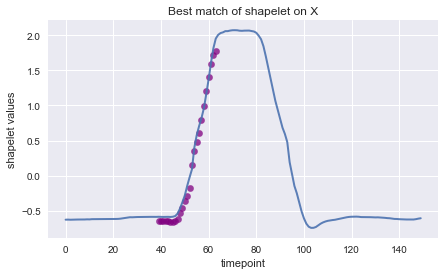

In [47]:
fig = shp_vis.plot_on_X(X_test[1], figure_options={"figsize": (7, 4)})

Or we can visualize the distance between the shapelet $S$ and all subsequences the same size in $X$. We refer to this as the **distance vector** between $S$ and $X$, and its defined as 

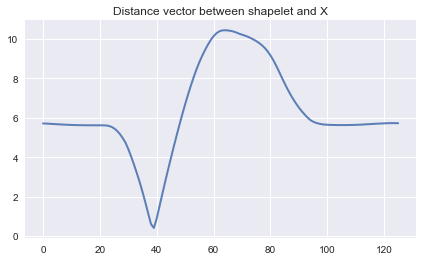

In [48]:
fig = shp_vis.plot_distance_vector(X_test[1], figure_options={"figsize": (7, 4)})

# From Shapelet trees to the Shapelet Transform

A bit later the Shapelet Transform [[2]](https://ueaeprints.uea.ac.uk/id/eprint/40201/1/LinesKDD2012.pdf) was introduced as an alternative to shapelet-based decision trees. Their idea was to use shapelets not as a splitting criterion in a tree, but as a way to extract features from time series, in order to be able to use any kind of tabular classifier. In this method, only one feature was extracted from each time series $X$ and each shapelet $S$ : the distance $dist(S,X)$.

Given a set of $k$ shapelet ${\cal S} = [S_1, \ldots, S_k]$, this allows to create an embedding ${\cal X}'$ of a time series dataset ${\cal X} = [X_1, \ldots, X_n]$ such as :

$\displaystyle{{\cal X}' = \begin{bmatrix}
dist(S_1, X_1) & ... & dist(S_k, X_1) \\
... & ... & ... \\
dist(S_1, X_n) & ... & dist(S_k, X_n) 
\end{bmatrix}}$

Which can be used as a tabular dataset with $k$ features by any tabular classifier. In aeon, every shapelet-based transformation algorithm is following this same reasoning, with some extracting more than one feature per shapelet (for example [RDST](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.transformations.collection.shapelet_based.RandomDilatedShapeletTransform.html), which extract 3 features, giving $3k$ features). 

We can list all the available shapelet transformer in aeon by doing the following :




In [16]:
from aeon.registry import all_estimators

for k, v in all_estimators("transformer", filter_tags={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>


Let us for example select the `RandomShapeletTransform` transformer, we can use the `fit` and `transform` functions to obtain the time series embdeding :

In [18]:
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

st = RandomShapeletTransform(max_shapelets=10).fit(X_train, y_train)
st.transform(X_test).shape

(150, 10)

As planned, we obtain a matrix of size $(n,k)$ ! Given a fitted instance of any shapelet-based transformations, we can use another visualization class to plot the shapelets that were extracted :

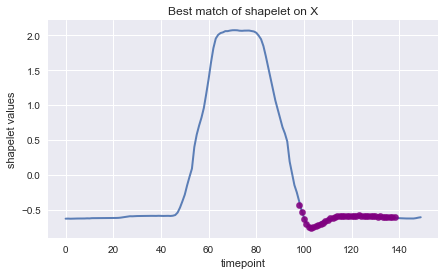

In [49]:
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform
from aeon.visualisation import ShapeletTransformerVisualizer

st = RandomShapeletTransform(max_shapelets=10).fit(X_train, y_train)
st_vis = ShapeletTransformerVisualizer(st)
id_shapelet = 0  # Identifier of the shapelet

fig = st_vis.plot_on_X(id_shapelet, X_test[1], figure_options={"figsize": (7, 4)})

You can also create and customize your own shapelet plots with this class, for example :


Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

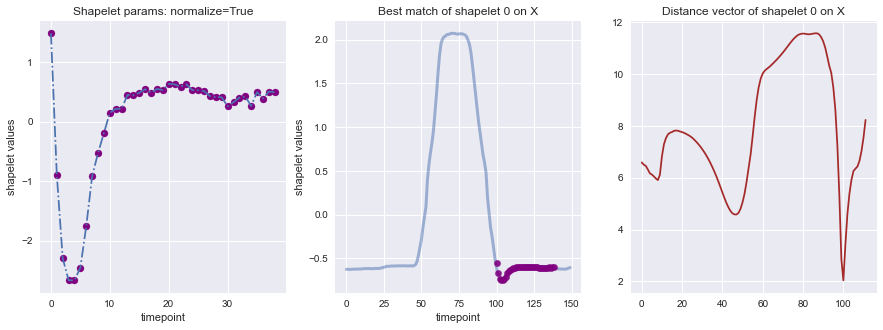

In [40]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
st_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
st_vis.plot_on_X(
    id_shapelet, X_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
st_vis.plot_distance_vector(
    id_shapelet, X_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

## Normalized shapelets

Notice how in the above plot, the shapelet values (left-most plot) do not match the ones used to position it on the time series. This is due to the fact that in `RandomShapeletTransform`, all shapelets use a normalized distance. This have the effect of making the shapelet **scale-invariant**. This mean that the best match to the shapelet will now be a subsequence of the shape **shape** independently of its **scale**. This is the case for most shapelet transformation estimator in aeon. In the `RandomDilatedShapeletTransform` [3], you can tune the `proba_normalization` parameter to modify the probability that a shapelet will be initialized with a normalized distance during `fit`.


To achieve this, both the shapelet values and the subsequences values are z-normalized prior to computing $dist(S,X)$, for example to z-normalize $S$, we first compute $\mu_S$ and $\sigma_S$, respectively the mean and standard deviation of $S$ and obtain its normalized version $\bar{S}$ as :

$\displaystyle{\bar{S} = \frac{(S - \mu_S)}{\sigma_S}}$


# How are shapelet extracted from the time series ?

Now that we understand what shapelets are and how they are used, a question is left unanswered, how do we extract them ? This process is hidden behind the `fit` method of the shapelet-based transformations. We can distinguish x type of shapelet extraction process:

- **Exaustive search** : In this case, we extract all possible shapelet candidates (i.e. all subsequences of a given length) and evalute their quality to extract the best ones. For example, after removing self-similar shapelets, we can compute the information gain of a shapelet $S$ based on $dist(S,X) < \lambda$, as done in the shapelet-tree of [1], or as in [2] with the F-statistic of a fixed effects ANOVA.
  
- **Heuristic-based search**: One issue of the exhaustive search is that it can take a long time to extract and evaluate all shapelet candidates in a dataset. A lot different approaches are proposed in the litterature to try to approximate the result of the exaustive search while minimizing the time needed to obtain the shapelets.
    - For example, instead of evaluating all possible candidates, `RandomShapeletTransform` use a parameter `n_shapelet_samples` to randomly extract a limited number of shapelets from the input. It then restrict the quality evaluation to these randomly extracted candidates to reduce the search time. It also consider the notion of self-similar shapelets during extraction to avoid sampling similar shapelets.
    - Others such as `SAST`[4] only select a small number of "reference" time series in the training data where all subsequences will be considered as shapelets without evaluating their quality. This leave the "feature selection" step to the classifier that will use the transformation. `RSAST`[5] use the same approach but use some statistical critera to further reduce the number of candidates extracted from these reference time series.
    - Another approach used in `RandomDilatedShapeletTransform` is to use a semi-random extraction which is guided by a masking of the input space. Once a shapelet have been randomly sampled from a time series, the neighboring points around the sampling point are removed from the list of available sampling points. This avoid extracting self-similar shapelets and improve the diversity of the extracted shapelet set. The number of neighboring point affected by this process is controlled with the `alpha_similarity` parameter.

- **Shapelet generation**: This last approach takes another view at the problem: What if the best shapelets for my dataset are not present in the training data ? The goal is to use optimization methods, such as gradient descent or evolutionary algorithm, to generate shapelet values instead of extracting them from the input. The first shapelet generation method was Learning Shapelet [6], which due to the nature of the extraction, is only implemented as a classifier in aeon inside `LearningShapeletClassifier`.


## Shapelet "self-similarity"
We can visualize the notion of self similarity using the following image. Consider that we sample the shapelet highlighted in green, under self similarity (which is a special case of `alpha_similarity` where `alpha=1`), all the neighboring subsequences, which are stacked and highlighted in red, cannot be considered as shapelet candidates. The next valid candidates would be the ones highlighted in orange. The number of prunned candidates is determined by $\alpha \times l$ with $l$ the length of the sampled shapelet (in green).

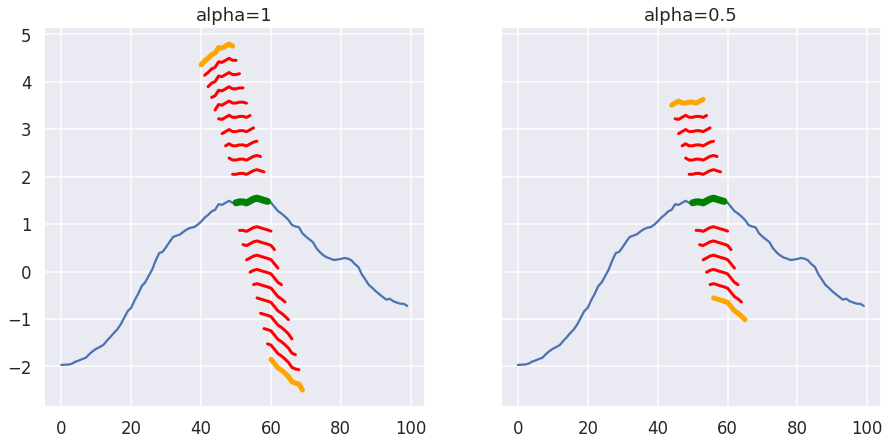

# Shapelet Transform for Classification

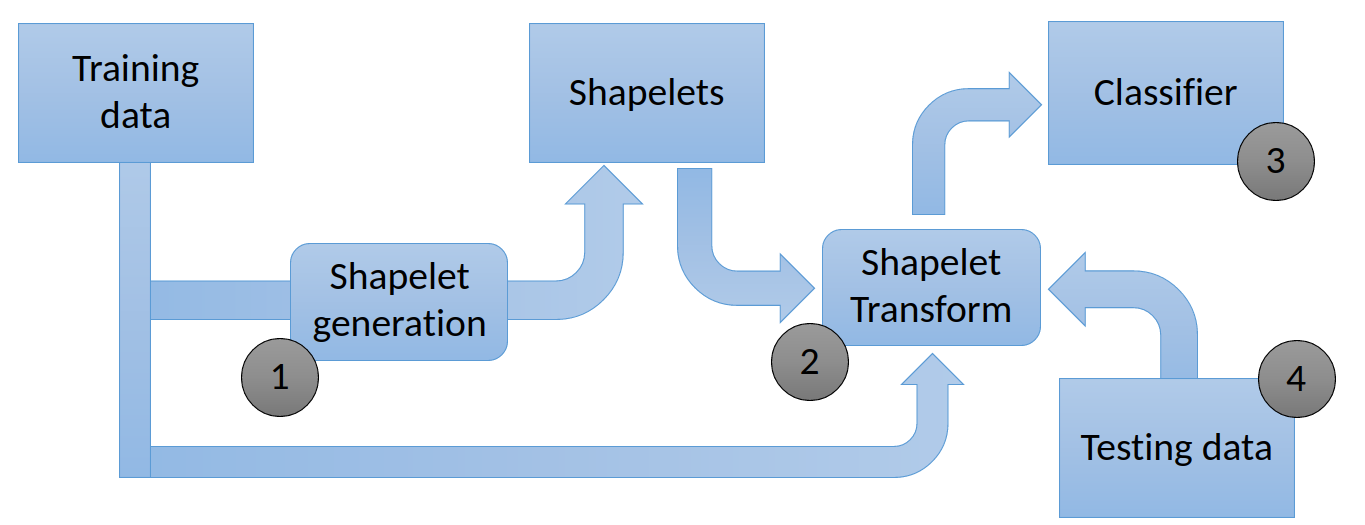

WIP FROM HERE

The `RandomShapeletTransform` transformer takes a set of labelled training time series in the `fit` function, randomly samples `n_shapelet_samples`  shapelets, keeping the best  `max_shapelets`. The resulting shapelets are used in the `transform` function to create a new tabular dataset, where each row represents a time series instance, and each column stores the distance from a time series to a shapelet. The resulting tabular data can be used by any scikit learn compatible classifier. In this notebook we will explain these terms and describe how the algorithm works. But first we show it in action. We will use the BasicMotions data as an example. This data set contains time series of motion traces for the activities "running", "walking", "standing" and "badminton". The learning problem is to predict the activity given the time series. Each time series has six channels: x, y, z position and x, y, z accelerometer of the wrist. Data was recorded on a smart watch.

In [1]:
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from aeon.datasets import load_basic_motions
from aeon.registry import all_estimators
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

warnings.filterwarnings("ignore")
all_estimators("classifier", filter_tags={"algorithm_type": "shapelet"})

C:\Users\antoine\Documents\aeon\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


[('LearningShapeletClassifier',
  aeon.classification.shapelet_based._ls.LearningShapeletClassifier),
 ('MrSQMClassifier',
  aeon.classification.shapelet_based._mrsqm.MrSQMClassifier),
 ('RDSTClassifier', aeon.classification.shapelet_based._rdst.RDSTClassifier),
 ('RSASTClassifier',
  aeon.classification.shapelet_based._rsast.RSASTClassifier),
 ('ShapeletTransformClassifier',
  aeon.classification.shapelet_based._stc.ShapeletTransformClassifier)]

In [2]:
X, y = load_basic_motions(split="train")
rst = RandomShapeletTransform(n_shapelet_samples=100, max_shapelets=10, random_state=42)
st = rst.fit_transform(X, y)
print(" Shape of transformed data = ", st.shape)
print(" Distance of second series to third shapelet = ", st[1][2])
testX, testy = load_basic_motions(split="test")
tr_test = rst.transform(testX)
rf = RandomForestClassifier(random_state=10)
rf.fit(st, y)
preds = rf.predict(tr_test)
print(" Shapelets + random forest acc = ", accuracy_score(preds, testy))

 Shape of transformed data =  (40, 8)
 Distance of second series to third shapelet =  1.302772121165026
 Shapelets + random forest acc =  0.95


## Dilated shapelets

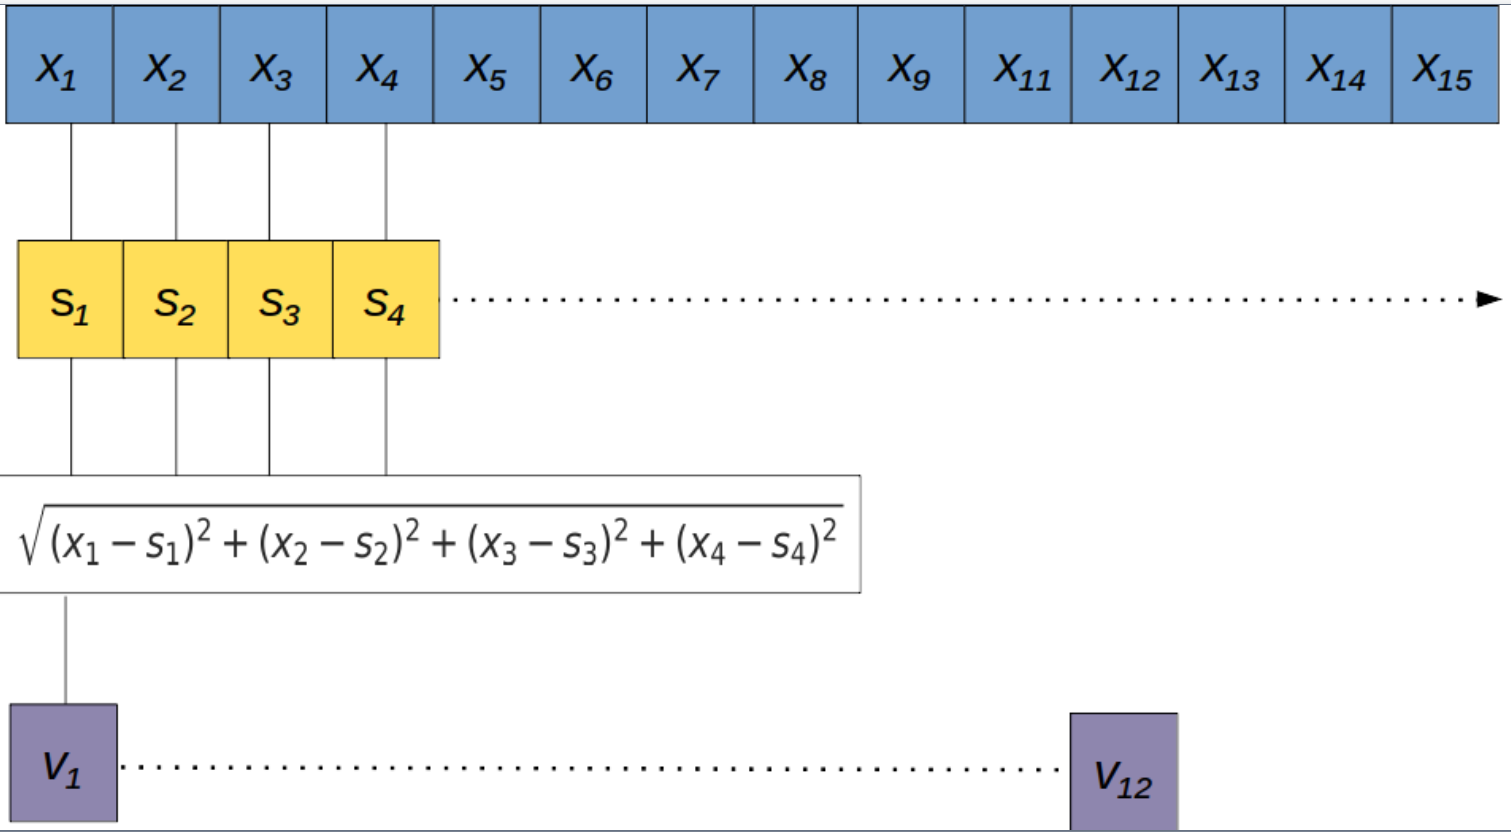


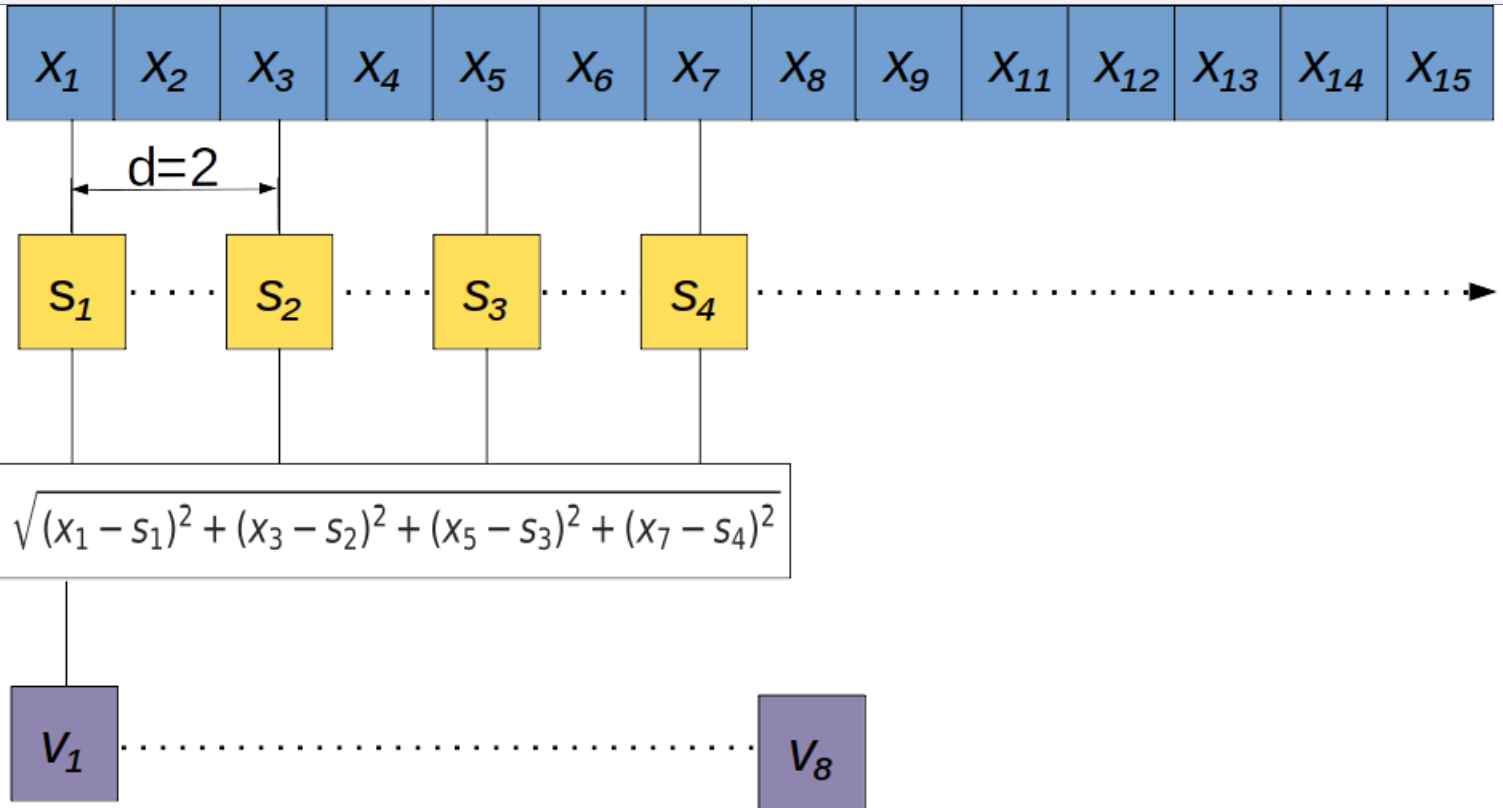


## Generalization to the multivariate case


## Generalization to the unequal length case

## Performance on the UCR univariate datasets

Our current shapelet classifiers are in the directory aeon.classification
.shapelet_based. We currently only have reference results for three of these.

In [6]:
all_shapelet_classifiers = [
    "MrSQMClassifier",
    "ShapeletTransformClassifier",
    "RDSTClassifier",
    "SASTClassifier",
    "RSASTClassifier",
    "LearningShapeletClassifier",
]
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

est = ["MrSQMClassifier", "RDSTClassifier", "ShapeletTransformClassifier"]
names = [t.replace("Classifier", "") for t in est]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 3)

(<Figure size 600x220 with 1 Axes>, <Axes: >)

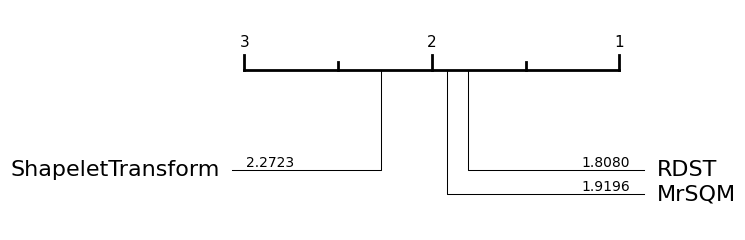

In [7]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

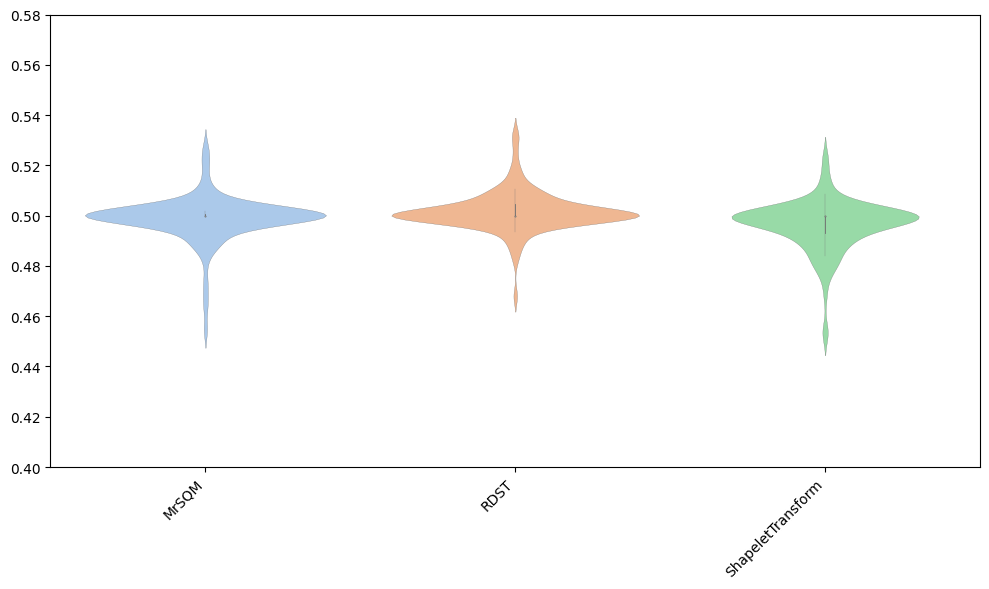

In [8]:
plot_boxplot_median(results, names)

## References

[1] L. Ye and E. Keogh. Time series shapelets: A new primitive for data mining. In Proc. 15th ACM SIGKDD, 2009

[2] J. Lines et al. A shapelet transform for time series classification. In Proc. 18th ACM SIGKDD, 2012.

[3] Antoine Guillaume et al. Random Dilated Shapelet Transform: A New Approach  for Time Series Shapelet. ICPRAI 2021.

[4] Mbouopda, Michael Franklin, and Engelbert Mephu Nguifo. Scalable and accurate subsequence transform for time series classification. Pattern Recognition 147, 2023.

[5] Varela, N. R., Mbouopda, M. F., & Nguifo, E. M. RSAST: Sampling  Shapelets for Time Series Classificatio. 2023.

[6] Grabocka, J. et al.  Learning time-series shapelets. In Pro.e 20th ACM SIGKD, 2014.).
